In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Study/Data Science/Megafon')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Исследование для «Мегафон»

## Данные

`megafon.csv` содержит следующие значения: <br><br>
&nbsp;&nbsp;&nbsp;&nbsp; `user_id` — идентификатор абонента;<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Q1` — ответ на первый вопрос;<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Q2` — ответ на второй вопрос;<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Total Traffic(MB)` — объем трафика передачи данных <sup>1 </sup>; <br>
&nbsp;&nbsp;&nbsp;&nbsp; `Downlink Throughput(Kbps)` — средняя скорость «к абоненту» <sup>2 </sup>;<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Uplink Throughput(Kbps)`— средняя скорость «от абонента» <sup>3 </sup>;<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Downlink TCP Retransmission Rate(%)` — частота переотправок пакетов «к абоненту» <sup>4 </sup>;<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Video Streaming Download Throughput(Kbps)` — скорость загрузки потокового видео <sup>5 </sup>;<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Video Streaming xKB Start Delay(ms)` — задержка старта воспроизведения видео <sup>6 </sup>;<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Web Page Download Throughput(Kbps)` — скорость загрузки web-страниц через браузер <sup>7 </sup>;<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Web Average TCP RTT(ms)` — пинг при просмотре web-страниц<sup>8 </sup>.<br>


<sup>1 </sup> — Насколько активно абонент использует мобильный интернет.<br>
<sup>2 </sup> — Считается по всему трафику передачи данных.<br>
<sup>3 </sup> — Считается по всему трафику передачи данных.<br>
<sup>4 </sup> — Чем выше, тем хуже. Если в канале возникает ошибка, пакет переотправляется. Снижается полезная скорость.<br>
<sup>5 </sup> — Чем выше, тем лучше — меньше прерываний и лучше качество картинки.<br>
<sup>6 </sup> — Сколько времени пройдёт между нажатием на кнопку Play и началом воспроизведения видео. Чем меньше это время, тем быстрее начинается воспроизведение.<br>
<sup>7 </sup> — Чем выше, тем лучше.<br>
<sup>8 </sup> — Чем меньше, тем лучше — быстрее загружаются web-страницы.<br>

Первый технический показатель представлен как сумма за период в одну неделю перед участием в опросе. Остальные технические показатели отображают среднее значение по данному признаку за период в одну неделю перед участием в опросе.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats

from scipy.stats import mannwhitneyu
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

SHAPE_CHART = (10, 6)

# Показатели сети
metrics = ['Total Traffic(MB)', 'Downlink Throughput(Kbps)', 'Uplink Throughput(Kbps)', 'Downlink TCP Retransmission Rate(%)',
         'Video Streaming Download Throughput(Kbps)', 'Video Streaming xKB Start Delay(ms)', 'Web Page Download Throughput(Kbps)',
         'Web Average TCP RTT(ms)']


df = pd.read_csv('megafon.csv')
df.head()

,user_id,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms)
0,1,5,NaN,775.48846,360.13,86.56,3.93,1859.15,2309,1007.82,83
1,2,5,4,861.96324,3023.54,411.18,1.27,667.47,2080,255.36,425
2,3,1,4,261.11860,790.96,34.20,1.79,1079.60,6367,535.85,485
3,4,8,3,179.18564,2590.97,325.88,0.80,7053.81,3218,1221.02,51
4,5,2,"2, 3, 4",351.99208,731.61,223.54,1.15,4550.38,1767,2336.56,68


# Анализ влияния технических показателей на удовлетворенность пользователей услугами

## ***Постановка задачи***

Планируется анализ влияния различных показателей сети на удовлетворенность пользователей услугами «Мегафон». Конкретные показатели, которые будут рассмотрены в рамках этого анализа, включают:

- Total Traffic(MB)
- Downlink Throughput(Kbps)
- Uplink Throughput(Kbps)
- Downlink TCP Retransmission Rate(%)
- Video Streaming Download Throughput(Kbps)
- Video Streaming xKB Start Delay(ms)
- Web Page Download Throughput(Kbps)
- Web Average TCP RTT(ms)

Выбор данного направления анализа обусловлен несколькими ключевыми моментами.

Во-первых, понимание того, как конкретные технические показатели сети влияют на удовлетворенность пользователей, позволит компании оптимизировать качество своих услуг, улучшая тем самым пользовательский опыт и укрепляя лояльность клиентов.

Во-вторых, в условиях высокой конкуренции на рынке мобильной связи, способность «Мегафон» предоставлять высококачественные услуги на основе объективных данных может стать существенным конкурентным преимуществом. Таким образом, анализ взаимосвязи между техническими характеристиками сети и удовлетворенностью пользователей даст компании возможность принимать более обоснованные решения в области инвестиций в инфраструктуру и техническую поддержку.

## ***Разведочным анализ***

Перед тем как перейти к статистическому анализу предполагаемых зависимостей, нужно осуществить разведочный анализ имеющихся данных по выбранным показателям сети. Целью данного этапа является визуальная оценка основных характеристик распределения данных, выявление аномалий, а также оценка потенциальных тенденций и особенностей данных.

**Анализ распределения показателей сети:**

1. **Total Traffic(MB)**: Данные этого показателя не следуют купольной форме, которая часто наблюдается в нормальных распределениях. Вместо этого, распределение данных имеет более центральное положение, что может свидетельствовать о наличии определенной стандартизации в трафике среди пользователей.

2. **Остальные показатели**: Почти все остальные рассматриваемые показатели имеют купольную форму распределения, однако они смещены влево, приближаясь к началу оси. Это может указывать на то, что большинство пользователей испытывают показатели сети в нижнем диапазоне возможных значений, что может влиять на их общее удовлетворение услугами.

На основе первичного визуального анализа данных можно сделать вывод, что имеются определенные особенности в распределении технических показателей сети среди пользователей. Эти тенденции, возможно, могут иметь влияние на уровень удовлетворенности пользователей, что делает актуальным дальнейший статистический анализ данных с целью выявления потенциальных зависимостей.

In [ ]:
# Почистим данные от корявых ответов на первый вопрос, тк они не несут инф. значимости
df['Q1'] = pd.to_numeric(df['Q1'], errors='coerce')
df = df[(df['Q1'] > 0) & (df['Q1'] < 11)]

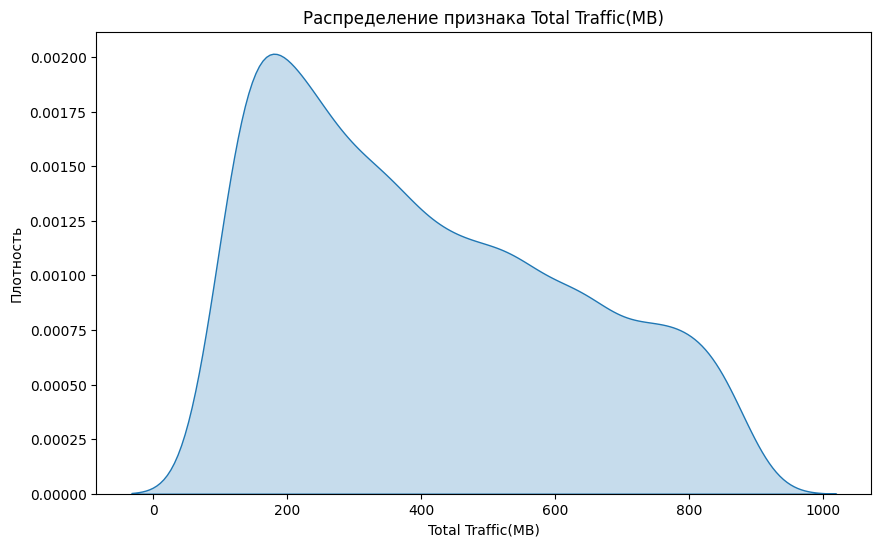

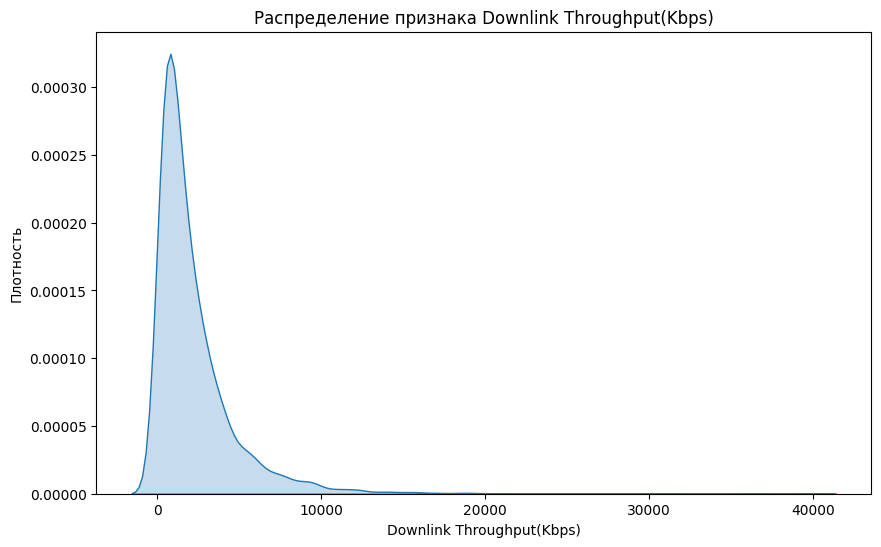

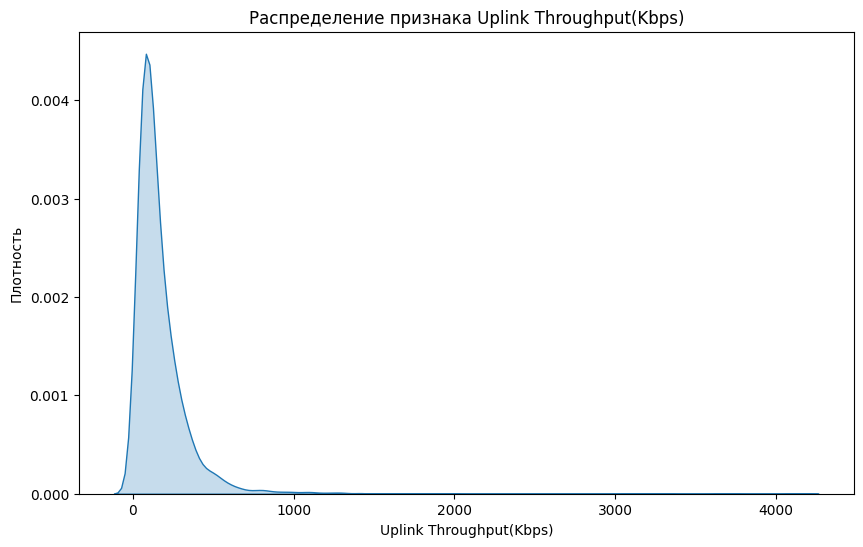

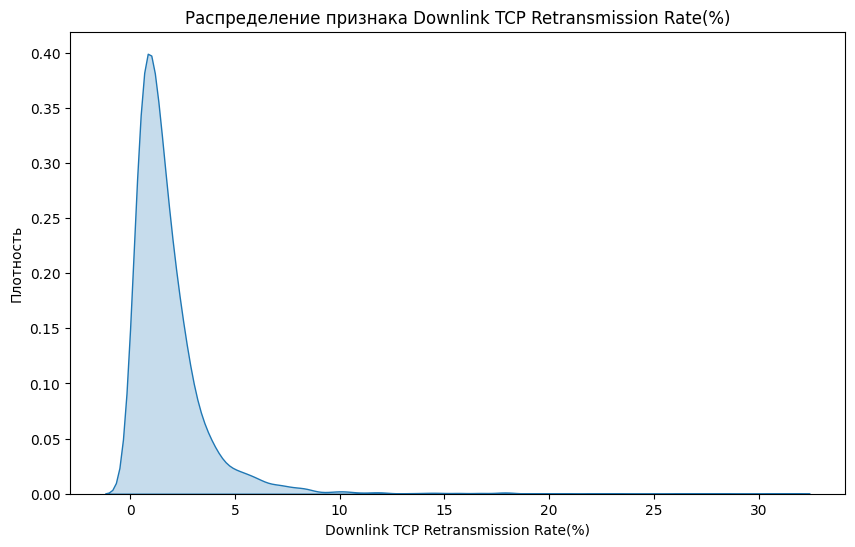

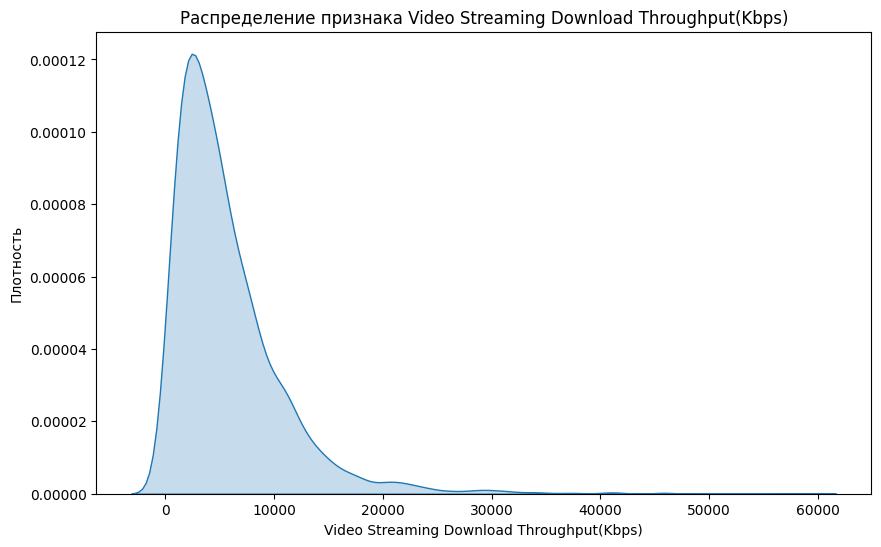

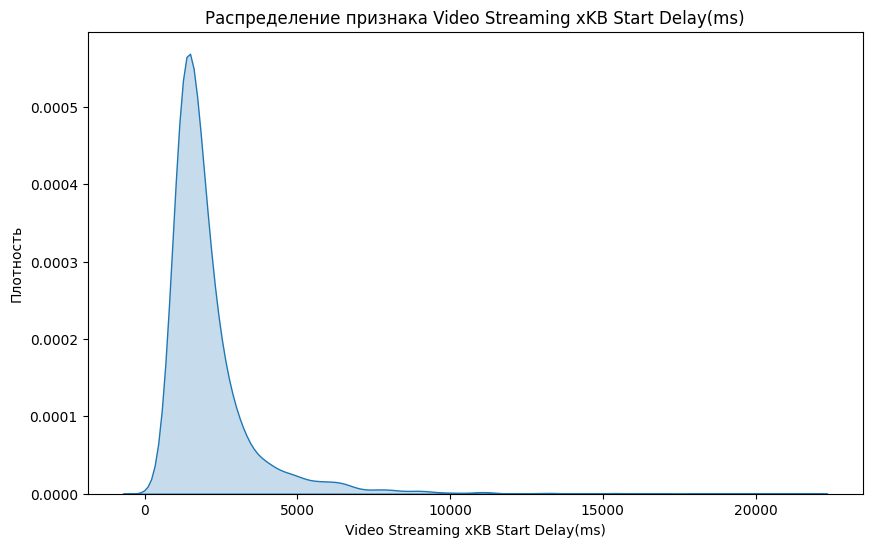

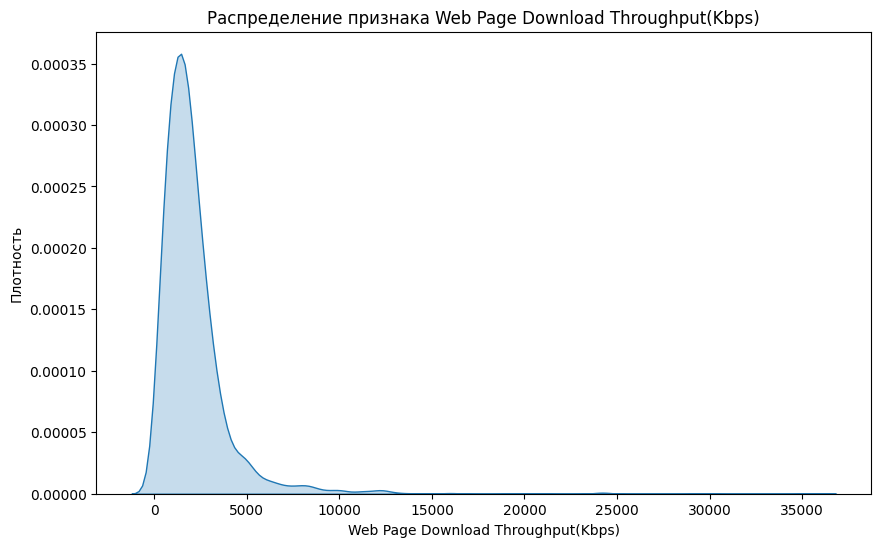

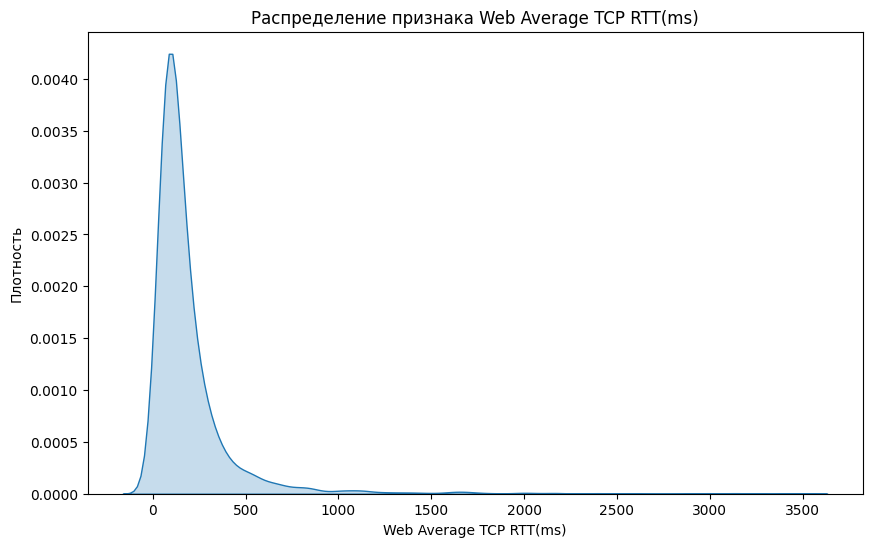

In [ ]:
for metric in metrics:
    fig, _ = plt.subplots(figsize=SHAPE_CHART)

    sns.kdeplot(df[metric], label=metric, shade=True)

    plt.title(f'Распределение признака {metric}')
    plt.ylabel('Плотность')
    plt.show()

## ***Статистический тест***

Для статистической проверки предположения о влиянии показателей сети на удовлетворенность пользователей был выбран метод bootstrap (бутстреп). Данный метод обладает следующими свойствами:

* Универсальность: Bootstrap является непараметрическим методом, что делает его применимым для данных различных распределений, в том числе и для тех, которые не соответствуют нормальному распределению.

* Размер выборки: Bootstrap особенно полезен, когда у нас есть ограниченный объем данных. Он позволяет оценить статистические характеристики путем многократного взятия подвыборок из наших данных.

* Гибкость: Этот метод позволяет оценить разнообразие статистик и моделей, основанных на выборках данных.

Также:

* Bootstrap, будучи непараметрическим методом, не требует строгого соответствия допущениям о нормальности распределения данных. Однако для эффективного применения метода следует учитывать:

* Независимость наблюдений: Данные должны быть IID (независимыми и одинаково распределенными).

In [ ]:
# Функция bootsrap
def bootstrap(data, n_iterations=1000):
    sample_means = []
    for _ in range(n_iterations):
        sample = np.random.choice(data, size=len(data), replace=True)
        sample_means.append(np.mean(sample))
    return sample_means

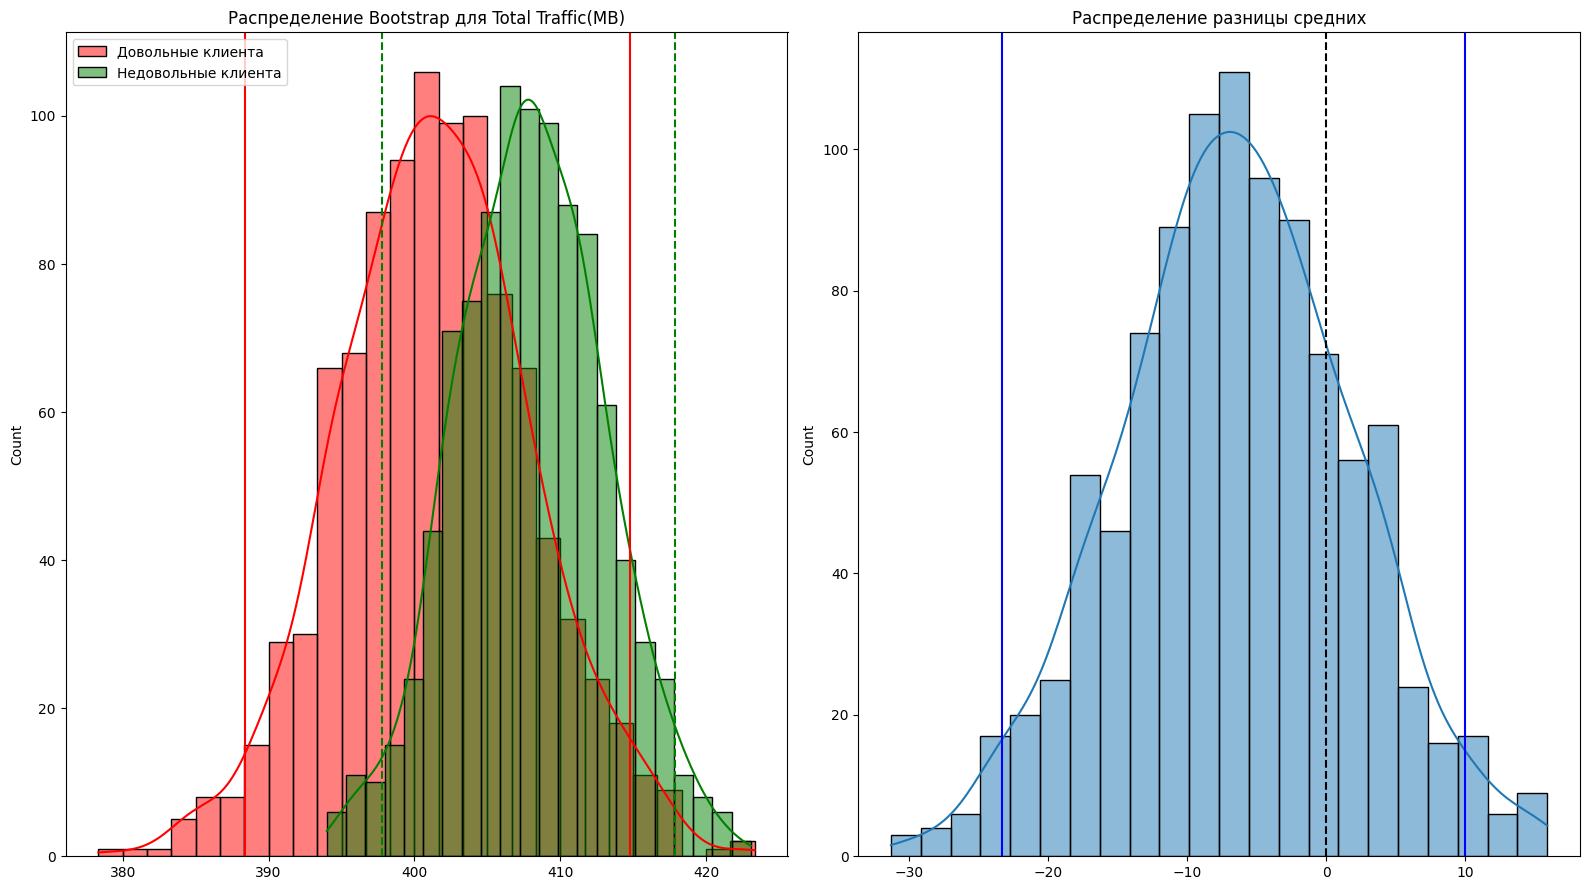

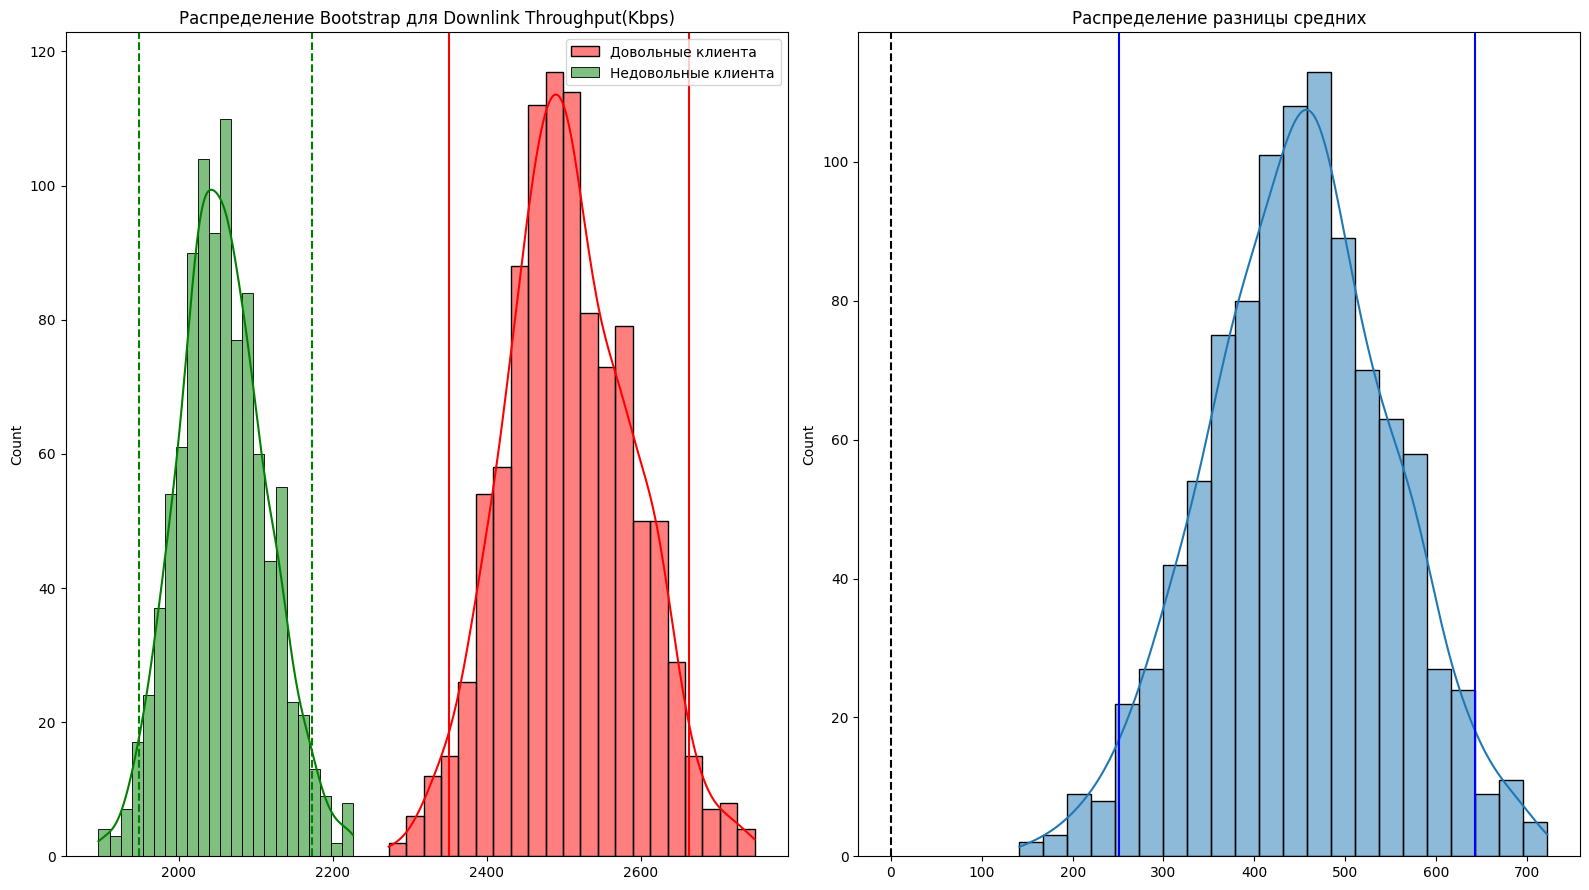

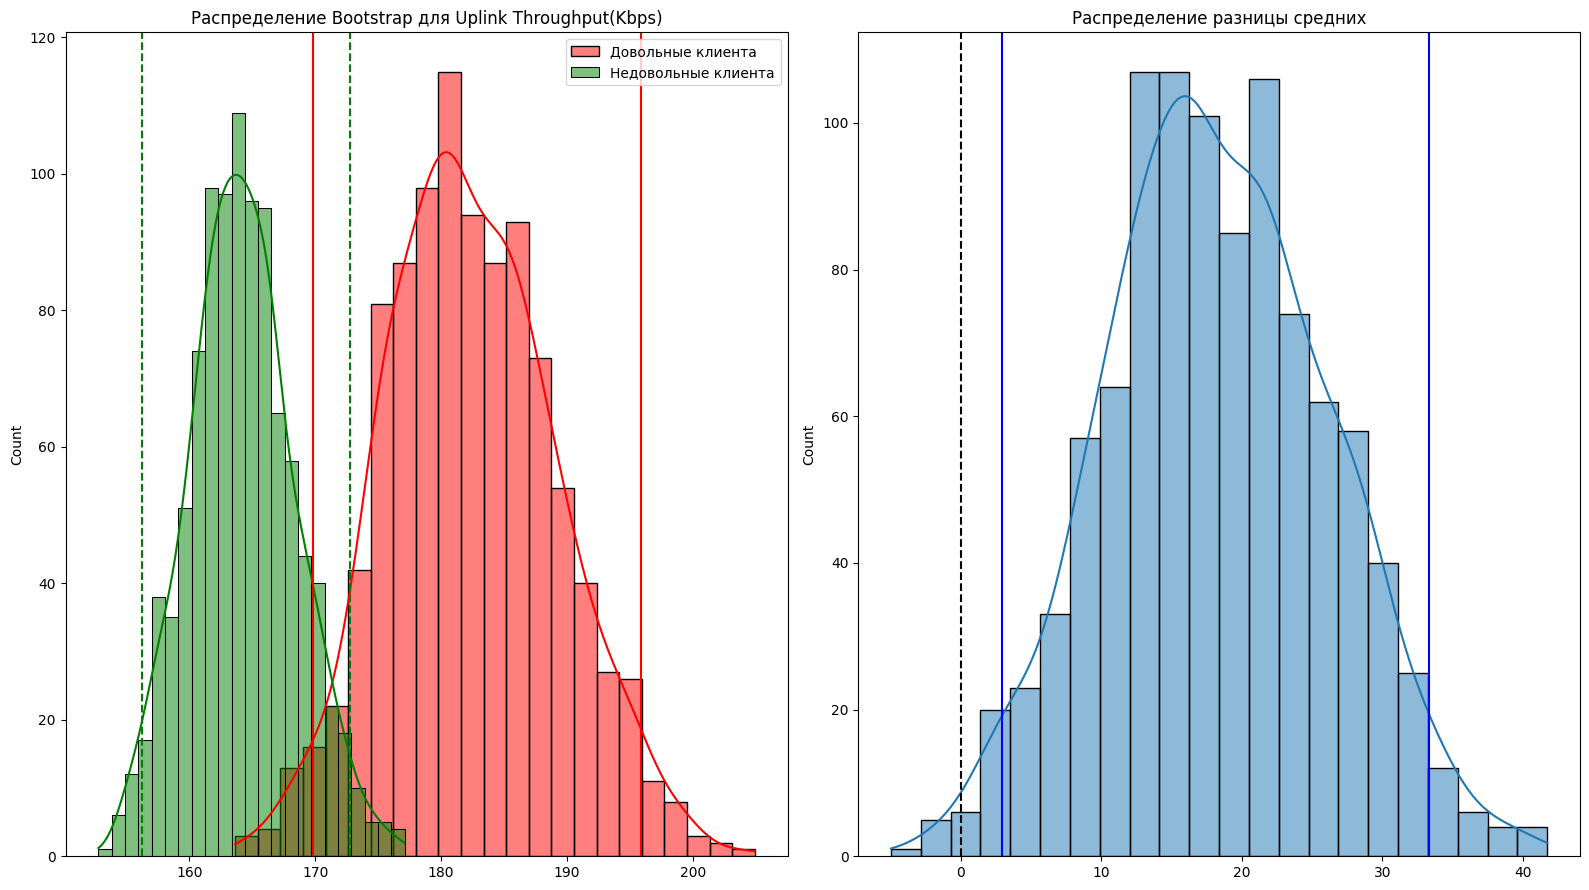

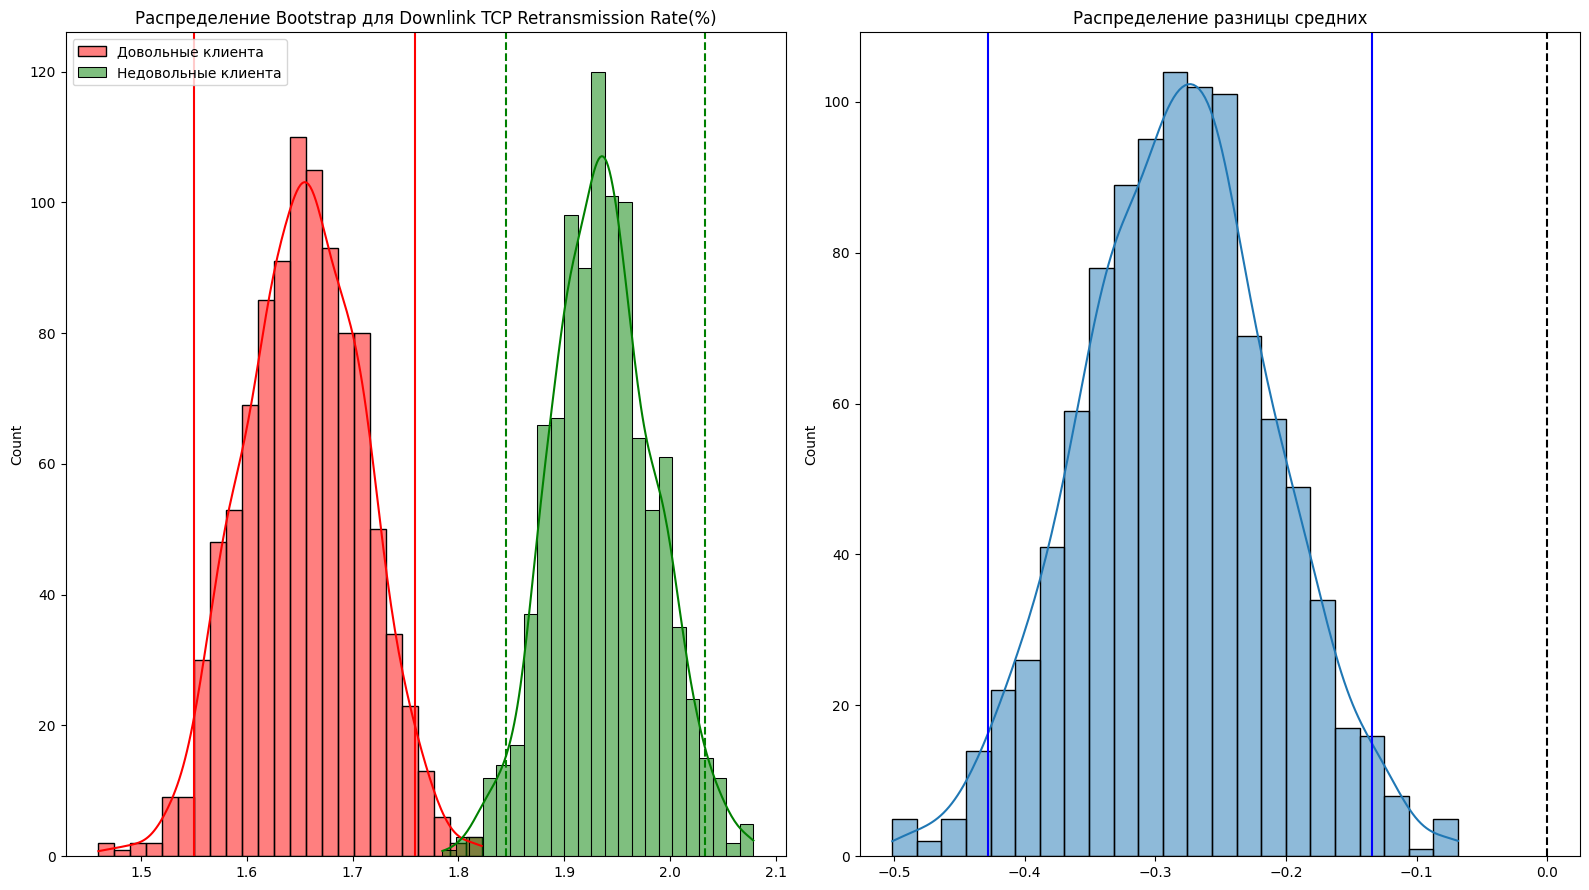

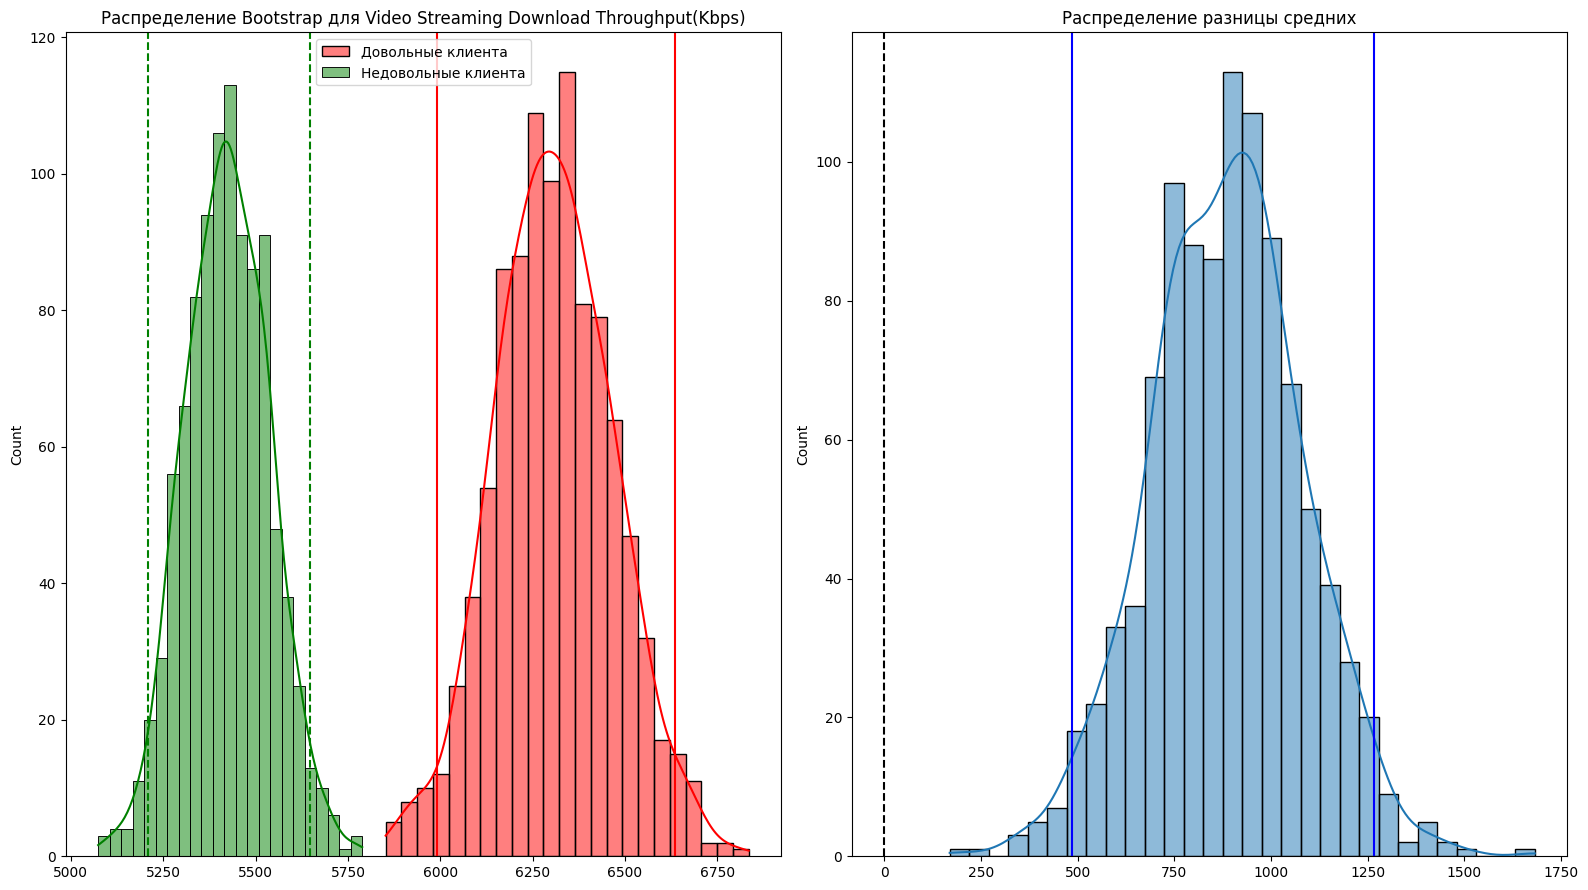

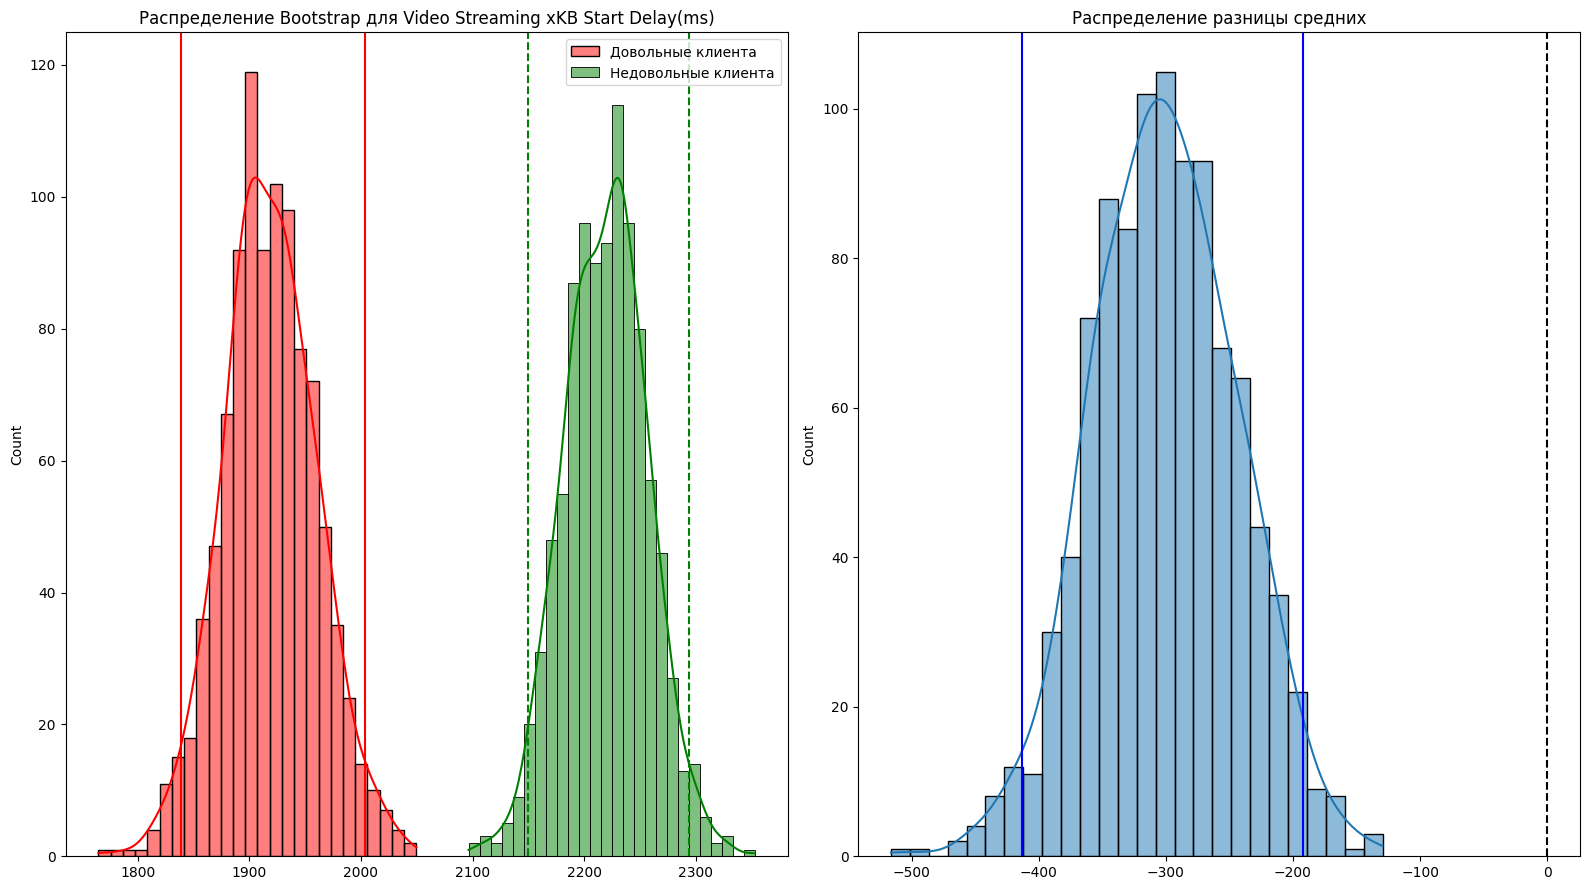

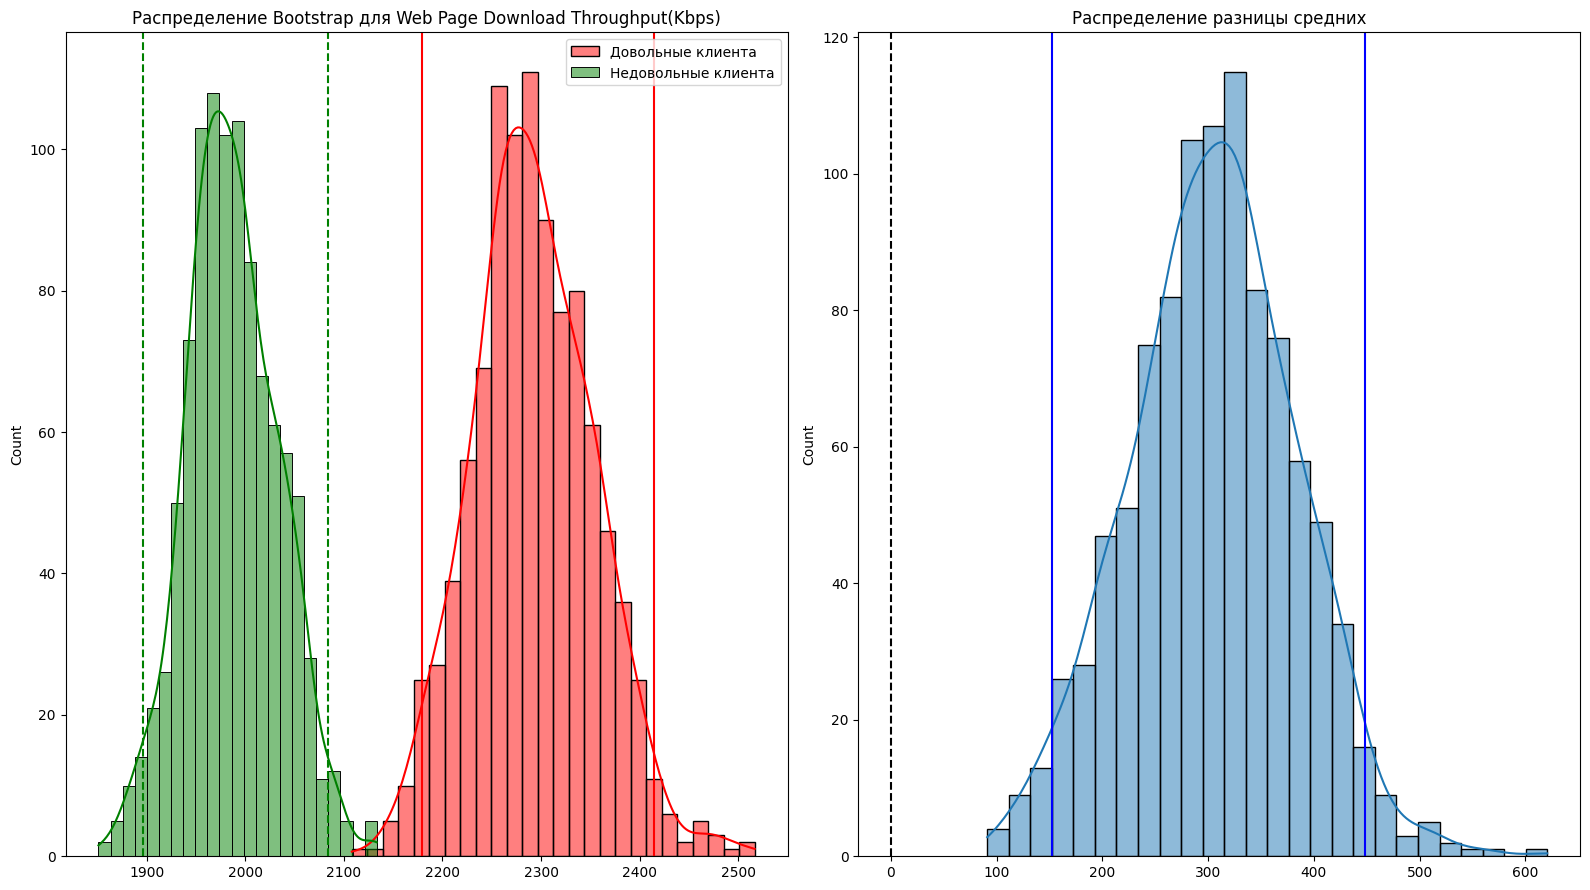

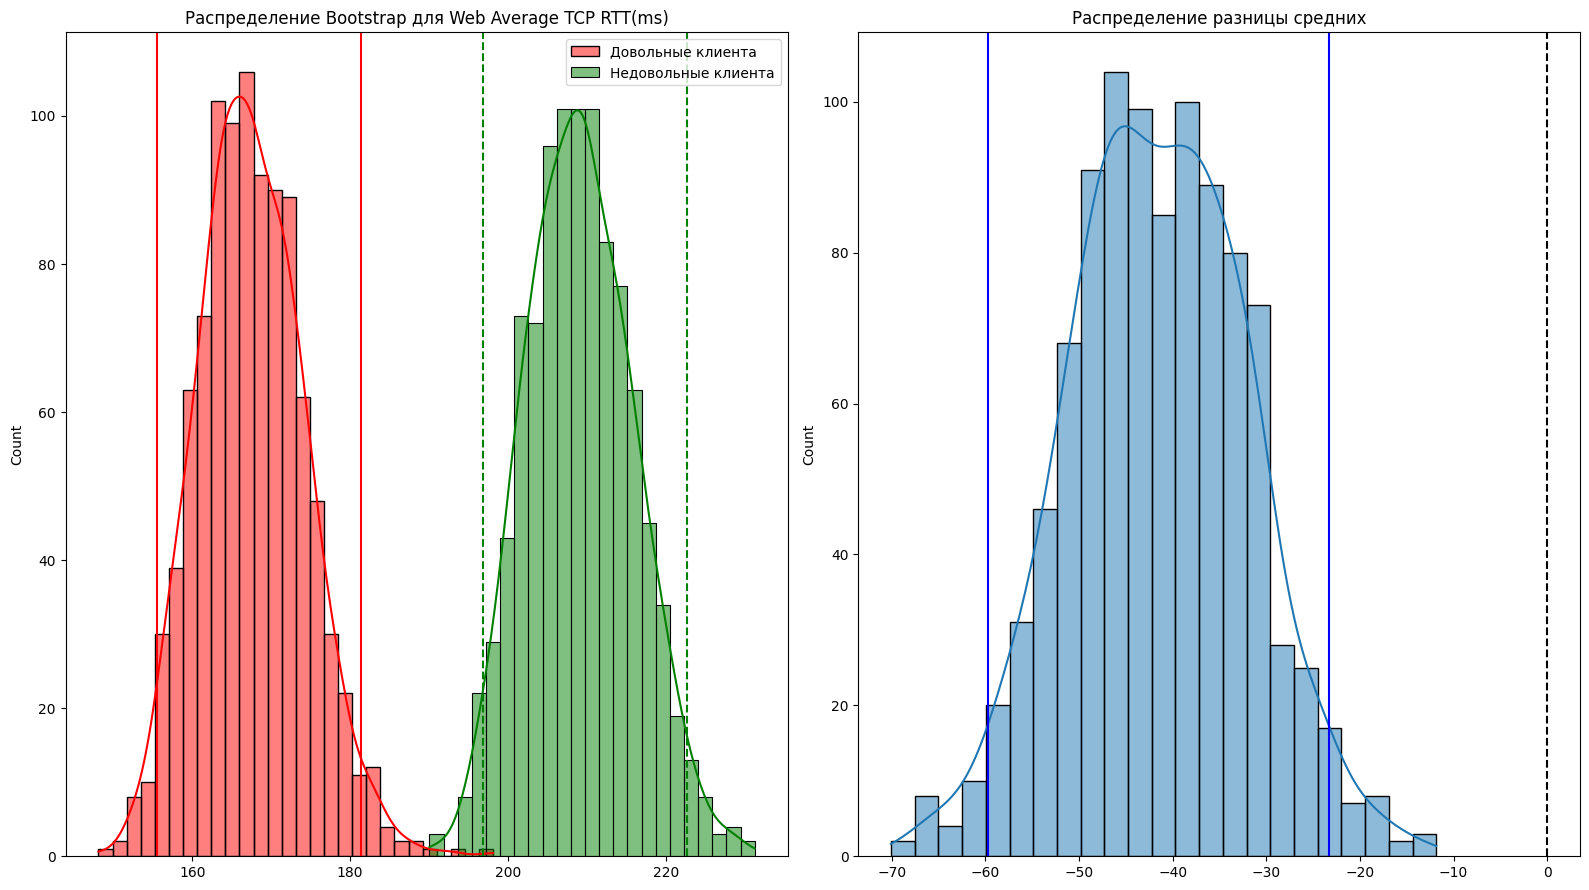

In [ ]:
for metric in metrics:
    # Делим данные на две группы
    happy_clients = df[df['Q1'].isin([9, 10])][metric].values
    not_happy_clients = df[~df['Q1'].isin([9, 10])][metric].values

    # Применяем бутстреп
    A = bootstrap(happy_clients)
    B = bootstrap(not_happy_clients)

    # Визуализируем распределения
    fig, axes = plt.subplots(1, 2, figsize=(16, 9))

    # График сгенерированных выборок
    sns.histplot(A, ax=axes[0], label='Довольные клиента', color='r', kde=True)
    sns.histplot(B, ax=axes[0], label='Недовольные клиента', color='g', kde=True)
    axes[0].axvline(np.percentile(A, 2.5), linestyle='-', color='r')
    axes[0].axvline(np.percentile(A, 97.5), linestyle='-', color='r')
    axes[0].axvline(np.percentile(B, 2.5), linestyle='--', color='g')
    axes[0].axvline(np.percentile(B, 97.5), linestyle='--', color='g')
    axes[0].legend()
    axes[0].set_title(f"Распределение Bootstrap для {metric}")

    # График разницы средних
    diff = np.array(A) - np.array(B)
    sns.histplot(diff, ax=axes[1], kde=True)
    axes[1].axvline(np.percentile(diff, 2.5), linestyle='-', color='blue')
    axes[1].axvline(np.percentile(diff, 97.5), linestyle='-', color='blue')
    axes[1].axvline(0, color='black', linestyle='--')
    axes[1].set_title("Распределение разницы средних")

    plt.tight_layout()
    plt.show()

## ***Вывод***

На основе проведенного bootstrap анализа можно сделать следующие выводы:

1. **Total Traffic(MB)**: Доверительные интервалы для этого показателя пересекаются, что указывает на отсутствие явных различий между группами. Хотя значение 0 входит в распределение разницы средних, оно не расположено по центру и может быть учтено в процентиле. Это может указывать на возможное, но не статистически значимое влияние данного показателя.

2. **Downlink Throughput(Kbps)**, **Downlink TCP Retransmission Rate(%)**, **Video Streaming Download Throughput(Kbps)**, **Video Streaming xKB Start Delay(ms)**, **Web Page Download Throughput(Kbps)** и **Web Average TCP RTT(ms)**: Доверительные интервалы для этих показателей не пересекаются, а значение 0 не входит в их распределение. Это указывает на явное и статистически значимое влияние этих показателей на удовлетворенность пользователей.

3. **Uplink Throughput(Kbps)**: Доверительные интервалы чуть-чуть пересекаются. Хотя значение 0 и входит в распределение разницы средних, оно не учитывается в процентиле, что может свидетельствовать о нестабильном влиянии этого показателя.

**Итог**: Большинство показателей сети, исключая Total Traffic(MB) и Uplink Throughput(Kbps), имеют статистически значимое влияние на удовлетворенность пользователей услугами. Возможно, у Total Traffic(MB) есть другие факторы, которые влияют на его ассоциацию с удовлетворенностью, или это просто случайное совпадение.

В завершении следует сделать акцент на том, что такие аналитические выводы помогут "Мегафону" определить ключевые показатели для улучшения и мониторинга, чтобы повысить удовлетворенность клиентов и качество предоставляемых услуг.

# Анализ влияния медианных значений технических показателей на удовлетворенность пользователей услугами

## ***Постановка задачи***

Выбор именно медианных значений показателей обусловлен несколькими причинами:

1. **Устойчивость к выбросам**: Медианное значение предоставляет наиболее релевантное представление о "типичном" пользовательском опыте, поскольку оно устойчиво к экстремальным значениям, которые могут искажать средние значения.
2. **Отражение реального пользовательского опыта**: Медиана может лучше отражать опыт большинства пользователей, особенно когда распределение данных асимметрично или имеет длинные хвосты.

Понимание того, как ключевые показатели сети, представленные их медианными значениями, влияют на удовлетворенность пользователей, может иметь ряд важных бизнес-последствий для «Мегафон»:

1. **Оптимизация инвестиций**: Основываясь на полученных данных, компания может эффективнее распределять инвестиции в инфраструктуру сети, улучшая те аспекты, которые наиболее влияют на удовлетворенность клиентов.
2. **Повышение лояльности**: Улучшение ключевых показателей, которые сильно влияют на удовлетворенность пользователей, может привести к уменьшению оттока клиентов и увеличению их лояльности.
3. **Стратегическое планирование**: Инсайты, полученные из анализа, помогут компании в формировании стратегических планов на будущее, сосредотачивая усилия на наиболее важных для клиентов аспектах.

В заключение, этот анализ поможет «Мегафону» лучше понять своих пользователей и их потребности, что, в свою очередь, приведет к более обдуманным и целенаправленным бизнес-решениям.

## ***Разведочный анализ***

Скрипичные диаграммы (Violin plots) комбинируют преимущества ящиков с усами (box plots) и сглаженных графиков плотности (kernel density plots). Они помогают визуализировать распределение данных, отображая плотность распределения в разных значениях.

**Разведочный анализ данных (EDA) по показателям сети:**

1. **Total Traffic(MB):** Для обеих групп клиентов (счастливых и несчастливых) распределение показателя "Total Traffic(MB)" примерно одинаковое как по форме, так и по медианным значениям. Это может указывать на то, что общий трафик, который потребляется клиентами, не влияет на их уровень удовлетворенности.

2. **Downlink Throughput(Kbps):** У неудовлетворенных клиентов график немного шире, и медианное значение выше. Это может говорить о том, что эти клиенты сталкиваются с более высокой пропускной способностью при загрузке, но, возможно, их не устраивают другие аспекты услуги.

3. **Uplink Throughput(Kbps):** Аналогично ситуации с Downlink Throughput, у неудовлетворенных клиентов график немного шире, но медианное значение выше у удовлетворенных клиентов. Это может указывать на возможные проблемы с загрузкой у неудовлетворенных клиентов.

4. **Downlink TCP Retransmission Rate(%):** У удовлетворенных клиентов график шире, и медианное значение меньше, что может указывать на лучшую стабильность соединения.

5. **Video Streaming Download Throughput(Kbps):** У неудовлетворенных клиентов график шире и медианное значение выше, что может говорить о проблемах с просмотром видео.

6. **Video Streaming xKB Start Delay(ms):** У удовлетворенных клиентов график шире и медианное значение меньше, указывая на быстрее начало потокового воспроизведения видео.

7. **Web Page Download Throughput(Kbps):** Хотя формы распределения похожи для обеих групп, медианное значение выше у неудовлетворенных клиентов.

8. **Web Average TCP RTT(ms):** У удовлетворенных клиентов график шире и медианное значение меньше, что может говорить о быстром времени отклика для веб-сессий.

На основе проведенного анализа можно предположить, что не все показатели сети имеют одинаковое влияние на уровень удовлетворенности клиентов. Некоторые показатели, такие как Downlink Throughput и Video Streaming Download Throughput, могут иметь большое значение для определенных групп пользователей, в то время как другие показатели, такие как Total Traffic, могут не влиять на удовлетворенность клиента.

In [ ]:
# Разделение клиентов на "happy" и "not_happy" на основе их оценок в 'Q1'
df['Удовлетворенность клиентов'] = df['Q1'].apply(lambda x: 'Удовлетворены' if x in [9, 10] else 'Не Удовлетворены')

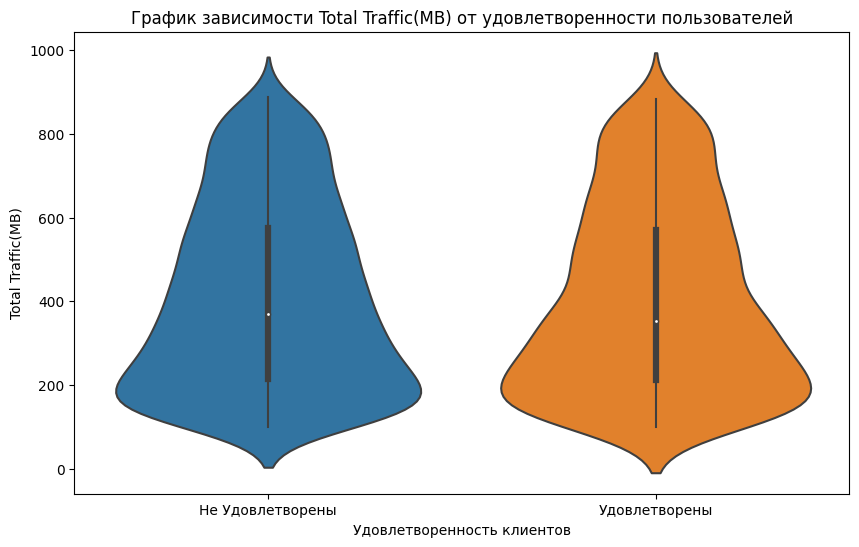

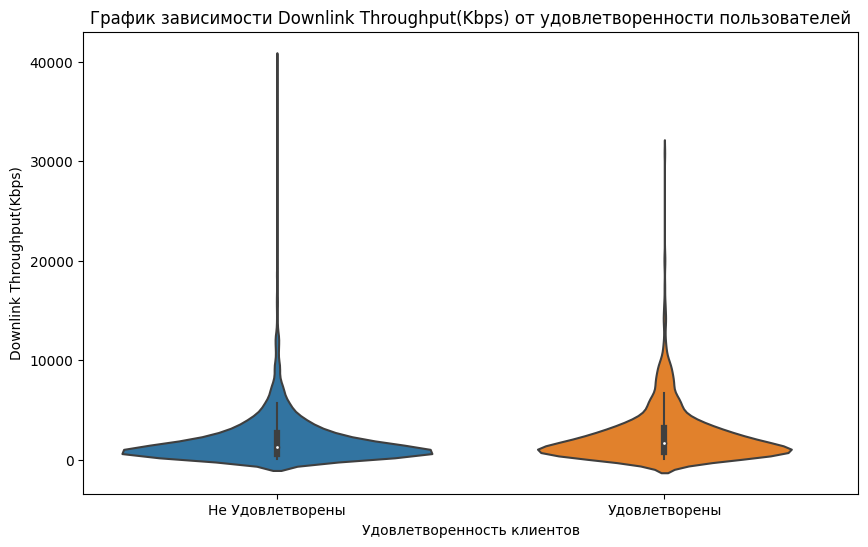

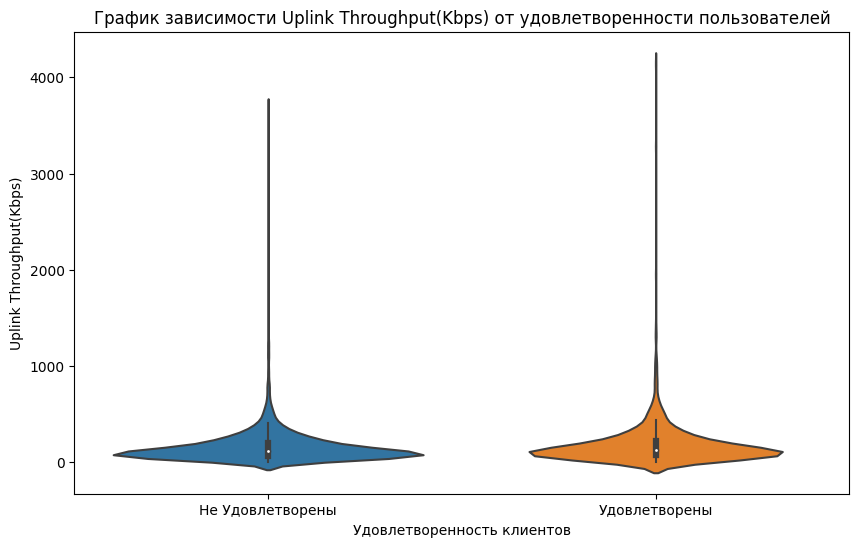

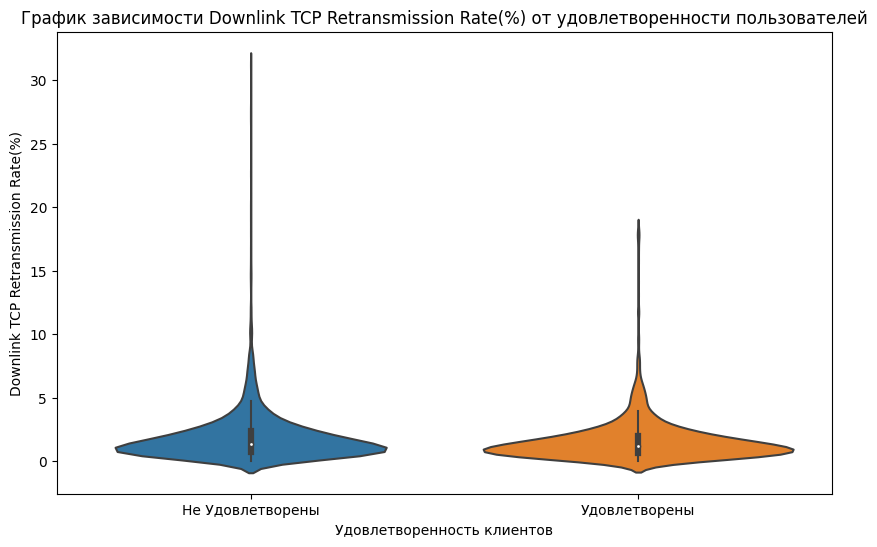

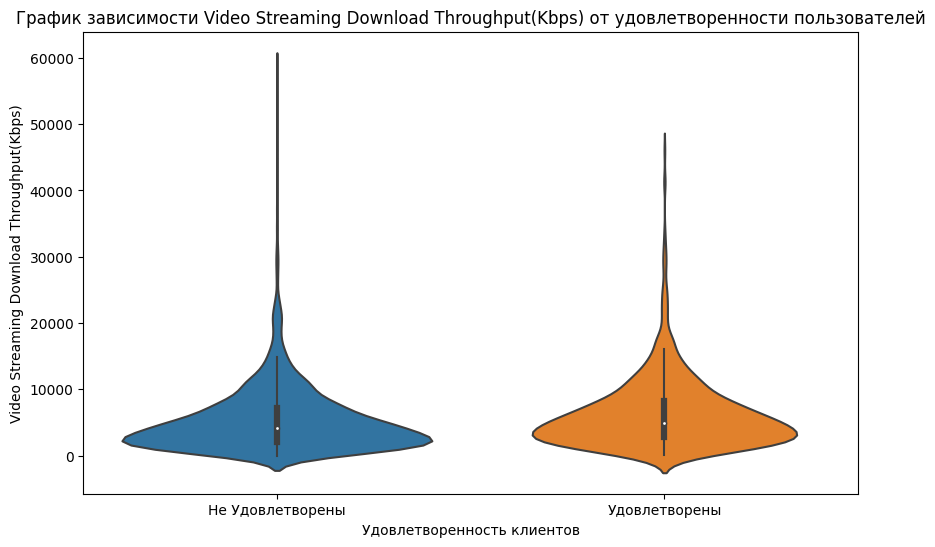

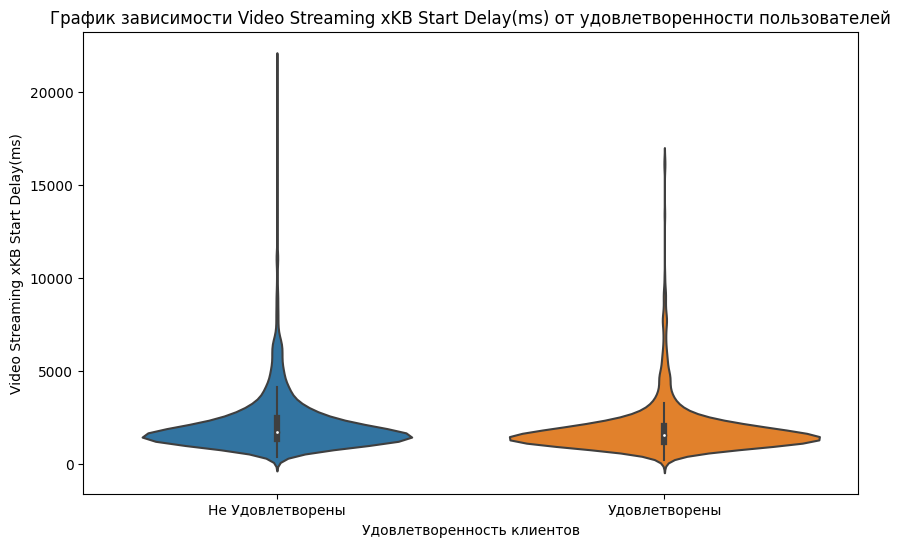

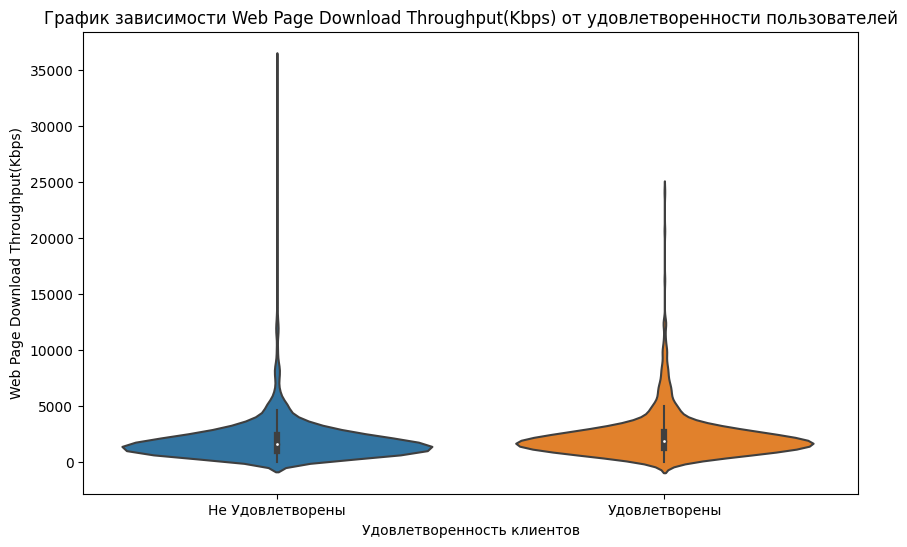

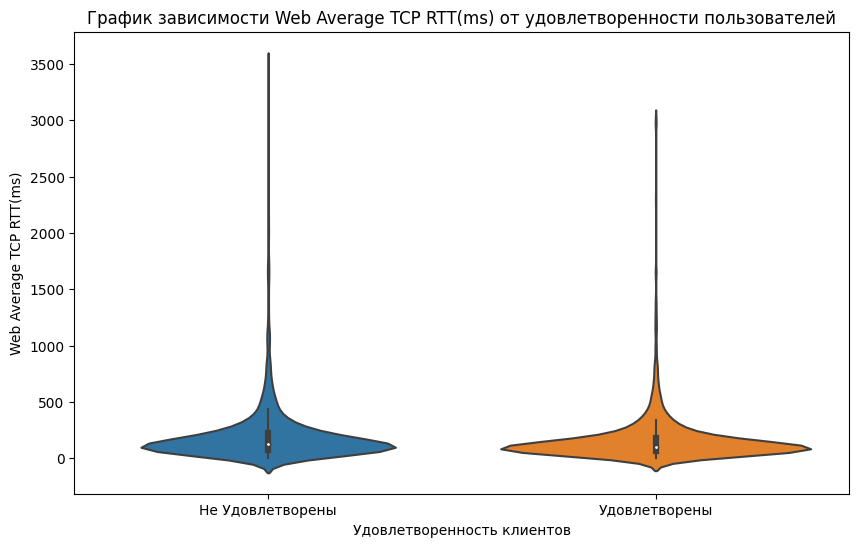

In [ ]:
for metric in metrics:
    plt.figure(figsize=SHAPE_CHART)
    sns.violinplot(x='Удовлетворенность клиентов', y=metric, data=df)
    plt.title(f'График зависимости {metric} от удовлетворенности пользователей')
    plt.show()

## ***Статистический тест***

Тест Манна-Уитни является непараметрическим методом, предназначенным для сравнения двух независимых выборок. Основные причины выбора этого метода:

1. **Ненормальное распределение данных:** Тест Манна-Уитни не делает предположений о нормальности распределения, что делает его идеальным выбором в данной ситуации.
  
2. **Сравнение рангов:** Этот тест основан на сравнении рангов, а не на самих значениях, что делает его устойчивым к выбросам и идеально подходящим для сравнения медианных значений в двух группах.

**Допущения теста:**

1. **Независимость выборок:** Данные в обеих группах (довольных и недовольных клиентов) должны быть независимыми.
  
2. **Ординальная шкала измерения:** Данные должны быть измерены по ординальной, интервальной или относительной шкале.
  
3. **Схожесть формы распределения:** Хотя тест Манна-Уитни позволяет проводить анализ при отличающихся формах распределения, предположение о схожести формы распределения обеих групп улучшает точность теста.

In [ ]:
for metric in metrics:
    stat, p = mannwhitneyu(df[df['Q1'].isin([9, 10])][metric], df[~df['Q1'].isin([9, 10])][metric])

    print(f'Для {metric}: \n статистика: {stat:.2};    p-значение: {p:.2}')

Для Total Traffic(MB): 
 статистика: 1e+06;    p-значение: 0.33
Для Downlink Throughput(Kbps): 
 статистика: 1.2e+06;    p-значение: 4e-08
Для Uplink Throughput(Kbps): 
 статистика: 1.1e+06;    p-значение: 0.02
Для Downlink TCP Retransmission Rate(%): 
 статистика: 9.6e+05;    p-значение: 2.1e-06
Для Video Streaming Download Throughput(Kbps): 
 статистика: 1.2e+06;    p-значение: 3.3e-09
Для Video Streaming xKB Start Delay(ms): 
 статистика: 9.1e+05;    p-значение: 2.3e-12
Для Web Page Download Throughput(Kbps): 
 статистика: 1.2e+06;    p-значение: 1.9e-10
Для Web Average TCP RTT(ms): 
 статистика: 9.3e+05;    p-значение: 2.7e-09


## ***Вывод***

На начальных этапах нашего исследования было выдвинуто предположение о возможном влиянии медианных значений показателей сети на удовлетворенность пользователей услугами компании "Мегафон". С этой целью были изучены различные показатели сети, такие как 'Total Traffic(MB)', 'Downlink Throughput(Kbps)' и другие. Наша основная задача заключалась в определении того, отличаются ли данные показатели между группами удовлетворенных и неудовлетворенных клиентов.

Результаты статистического теста Манна-Уитни следующие:

- **Total Traffic(MB)**: p-значение 0.33 указывает на отсутствие статистически значимых различий между двумя группами.
  
- **Downlink Throughput(Kbps), Uplink Throughput(Kbps), Downlink TCP Retransmission Rate(%), Video Streaming Download Throughput(Kbps), Video Streaming xKB Start Delay(ms), Web Page Download Throughput(Kbps), и Web Average TCP RTT(ms)**: Для всех этих показателей p-значение гораздо меньше 0.05, что говорит о статистически значимых различиях между группами удовлетворенных и неудовлетворенных клиентов.

Исходя из проведенного анализа, мы можем сделать вывод, что большинство показателей сети имеют статистически значимое влияние на удовлетворенность пользователей, за исключением 'Total Traffic(MB)'. Это может говорить о том, что параметры качества сети влияют на восприятие клиентами услуг, в то время как общий объем трафика не является ключевым показателем удовлетворенности.

Также данный тест почти полностью подтвердил выводы первого анализа при помощи bootstrap.

В тех случаях, где наше изначальное предположение не подтвердилось (например, 'Total Traffic(MB)'), возможно, клиенты оценивают другие аспекты сервиса или есть другие факторы, которые влияют на их удовлетворенность, которые мы не учли в данном исследовании.

# Анализ влияния технических показателей на выбор ответа "Медленный мобильный интернет"

## ***Постановка задачи***

Определение корреляции между показателями сети и ощущением пользователей о медленности интернета поможет нам понять, какие конкретные аспекты сети могут вызывать неудовлетворенность со стороны пользователей. Если пользователи часто жалуются на медленный интернет, важно узнать, какие конкретные технические показатели могут быть связаны с этими проблемами.

Понимание того, какие показатели сети влияют на восприятие скорости интернета пользователями, позволит "Мегафону" определить ключевые области для оптимизации и улучшения. Это может помочь в увеличении удовлетворенности клиентов, снижении количества жалоб и уменьшении оттока клиентов из-за проблем со скоростью интернета. Кроме того, это также даст возможность для инвестиций и улучшений в конкретные области сети, что, в свою очередь, может привести к более высокому уровню лояльности клиентов и увеличению доходов компании.

## ***Разведочный анализ***

Перед тем как перейти к статистическому анализу данных, мы решили взглянуть на графические представления данных для лучшего понимания тенденций и возможных закономерностей.

Тепловая карта ответов пользователей на вопрос о "Медленном мобильном интернете" в зависимости от различных категорий показателей сети выявила следующие особенности:

1. **Total Traffic(MB):** Большинство пользователей с высоким и низким трафиком ответили "Нет" на вопрос о медленном интернете, однако доля пользователей, ответивших "Да", примерно одинакова во всех категориях.

2. **Downlink Throughput(Kbps):** Пользователи с низкой пропускной способностью Downlink чаще жаловались на медленный интернет.

3. **Uplink Throughput(Kbps):** Различия между категориями невелики, но пользователи с низкой пропускной способностью Uplink немного чаще жаловались на медленный интернет.

4. **Downlink TCP Retransmission Rate(%):** Наибольшая доля жалоб на медленный интернет приходится на пользователей с высокой ставкой повторной передачи.

5. **Video Streaming Download Throughput(Kbps):** Пользователи с низкой пропускной способностью для загрузки видео-стриминга наиболее часто жаловались на медленный интернет.

6. **Video Streaming xKB Start Delay(ms):** Пользователи, у которых высокая задержка начала видео-стриминга, чаще жаловались на медленность интернета.

7. **Web Page Download Throughput(Kbps):** Пользователи с низкой пропускной способностью для загрузки веб-страниц наиболее часто сталкиваются с проблемой медленного интернета.

8. **Web Average TCP RTT(ms):** Большая задержка у пользователей, наиболее часто коррелирует с жалобами на медленный интернет.

На основе данных тепловой карты можно предположить, что некоторые технические показатели сети могут влиять на восприятие пользователем скорости интернета. В частности, показатели, связанные с пропускной способностью и временем задержки, кажутся наиболее значимыми в контексте жалоб на медленный интернет.

In [ ]:
# Преобразуем строку в список чисел, разделенных запятой
df['Q2'] = df['Q2'].str.split(',')

# Разделяем строки на несколько строк на основе списка
df = df.explode('Q2')

# Почистим данные от корявых ответов на вопрос, тк они не несут инф. значимости
df['Q2'] = pd.to_numeric(df['Q2'], errors='coerce')
df = df[(df['Q2'] >= 1) & (df['Q2'] <= 6)]

# Преобразуем в бинарный вид
df['Q2_4'] = df['Q2'].apply(lambda x: "Да" if x == 4 else "Нет")
_df = df.drop_duplicates(subset=['user_id', 'Q2_4'])

# Функция для разбиения показателя на категории
def get_bins(value, quantile1, quantile2):
    if value <= quantile1:
        return 'Низкая'
    elif value <= quantile2:
        return 'Средняя'
    else:
        return 'Высокая'

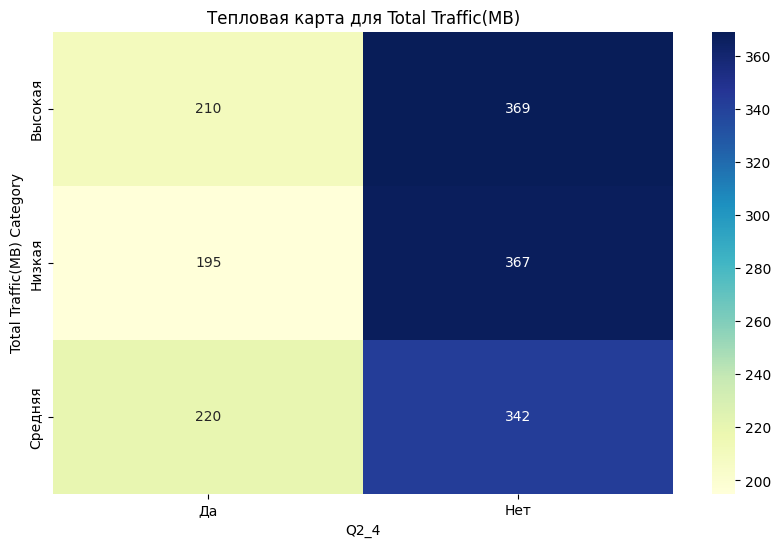

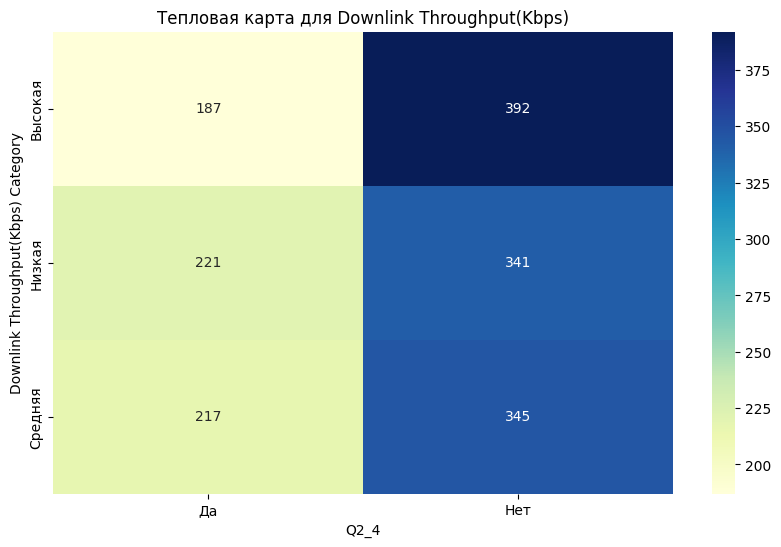

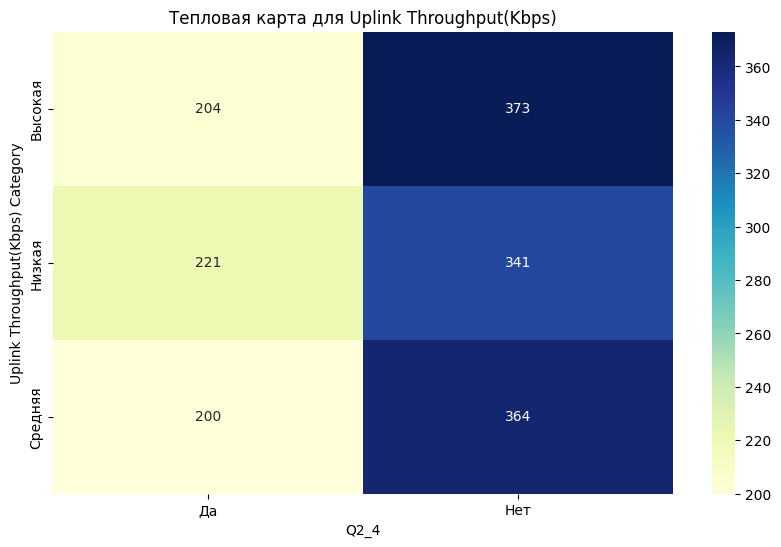

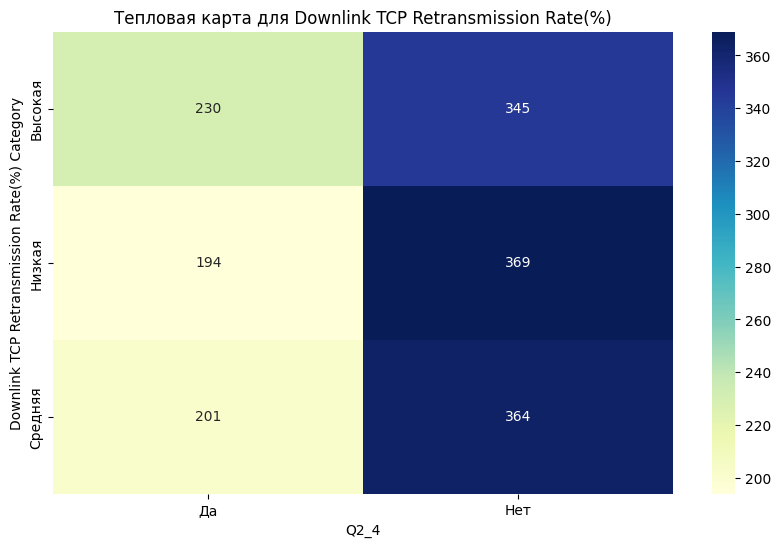

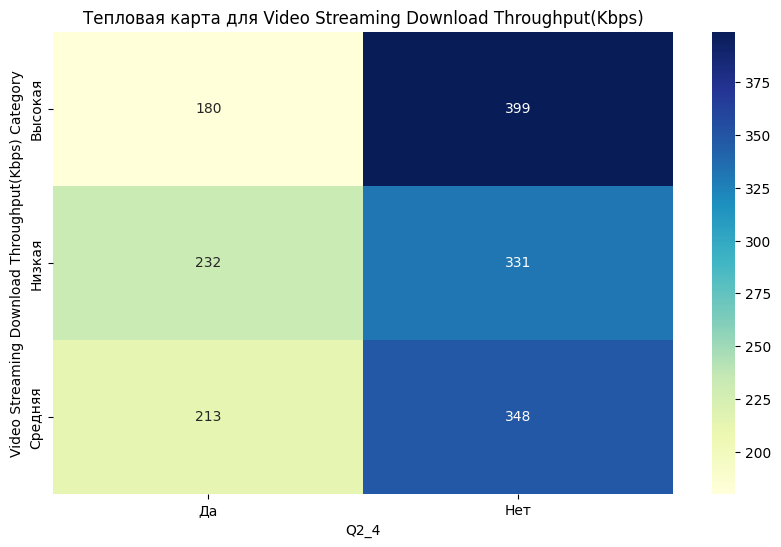

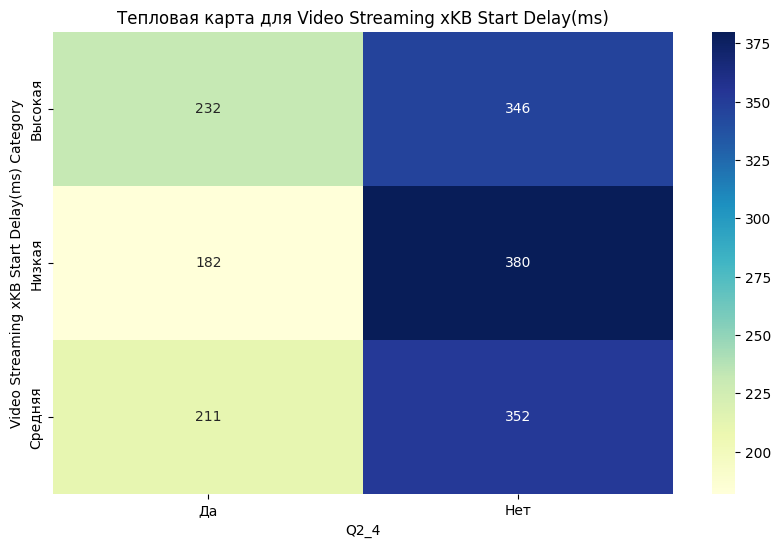

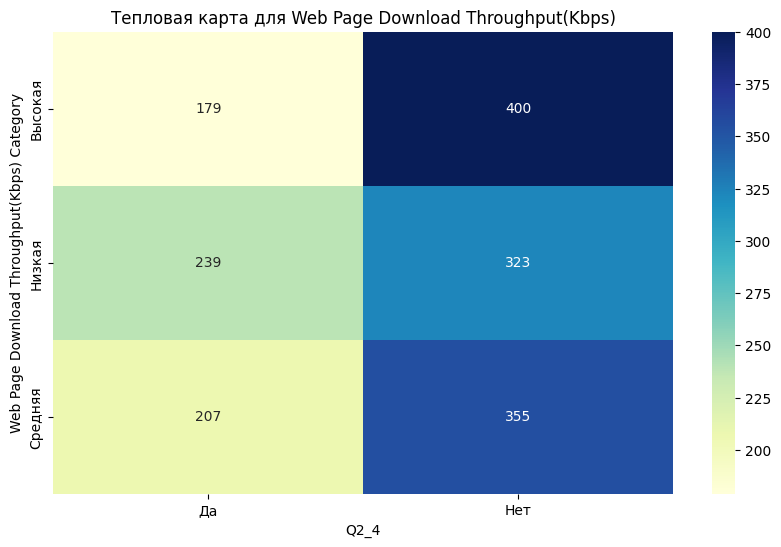

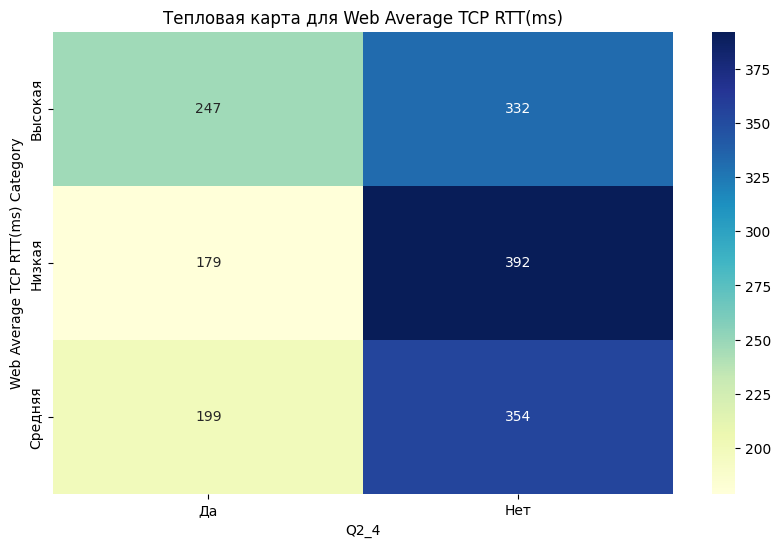

In [ ]:
contingency_tables = []

for metric in metrics:
    # Вычислим квантили
    quantile1 = _df[metric].quantile(0.33)
    quantile2 = _df[metric].quantile(0.66)

    _df[metric + ' Category'] = _df[metric].apply(get_bins, args=(quantile1, quantile2))

    # Таблица сопряженности 3x3
    contingency_table = pd.crosstab(_df[metric + ' Category'], _df['Q2_4'])
    contingency_tables.append(contingency_table)

    plt.figure(figsize=SHAPE_CHART)
    sns.heatmap(contingency_table, annot=True, cmap='YlGnBu', fmt='g')
    plt.title(f'Тепловая карта для {metric}')
    plt.show()

## ***Статистический тест***

Для оценки взаимосвязи между категориальными переменными, такими как ответ("Медленный мобильный интернет") и категориями показателей сети, наиболее подходящим является тест Хи-квадрат (χ2). Тест Хи-квадрат позволяет определить, есть ли статистически значимые различия между ожидаемыми и наблюдаемыми частотами в одной или нескольких категориях.

Обоснование выбора:
* Категориальные данные: Обе переменные (ответы на вопрос и категории показателей сети) являются категориальными.
* Независимость наблюдений: Каждое наблюдение должно быть независимым от других наблюдений, что, как предполагается, удовлетворяется в представленных данных.

Проверка допущений теста:
* Достаточный размер выборки: Для каждой ячейки ожидаемая частота должна быть не меньше 5. Учитывая представленные данные, это допущение выполнено.
* Независимость: Каждый случай или наблюдение должно входить только в одну категорию для каждой из переменных. Исходя из представленной тепловой карты, это допущение также выполнено.


In [ ]:
for contingency_table, metric in zip(contingency_tables, metrics):
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    print(f"Для {metric}: chi2 = {chi2:.2}, p = {p:.2}")

Для Total Traffic(MB): chi2 = 2.5, p = 0.29
Для Downlink Throughput(Kbps): chi2 = 7.4, p = 0.025
Для Uplink Throughput(Kbps): chi2 = 2.5, p = 0.29
Для Downlink TCP Retransmission Rate(%): chi2 = 4.2, p = 0.12
Для Video Streaming Download Throughput(Kbps): chi2 = 1.3e+01, p = 0.0014
Для Video Streaming xKB Start Delay(ms): chi2 = 7.6, p = 0.022
Для Web Page Download Throughput(Kbps): chi2 = 1.7e+01, p = 0.00025
Для Web Average TCP RTT(ms): chi2 = 1.6e+01, p = 0.00033


## ***Вывод***

**Результаты статистического анализа:**
1. **Total Traffic(MB)**: Нет статистически значимого влияния на ответы пользователей (p = 0.2918).
2. **Downlink Throughput(Kbps)**: Есть статистически значимое влияние (p = 0.0249).
3. **Uplink Throughput(Kbps)**: Нет статистически значимого влияния (p = 0.2883).
4. **Downlink TCP Retransmission Rate(%)**: Нет статистически значимого влияния (p = 0.1212).
5. **Video Streaming Download Throughput(Kbps)**: Очень сильное статистически значимое влияние (p = 0.0014).
6. **Video Streaming xKB Start Delay(ms)**: Статистически значимое влияние (p = 0.0224).
7. **Web Page Download Throughput(Kbps)**: Очень сильное статистически значимое влияние (p = 0.0003).
8. **Web Average TCP RTT(ms)**: Очень сильное статистически значимое влияние (p = 0.0003).

Наши данные подтвердили, что некоторые из рассмотренных показателей сети действительно влияют на восприятие пользователей о "Медленном мобильном интернете". В частности, это касается 'Downlink Throughput(Kbps)', 'Video Streaming Download Throughput(Kbps)', 'Video Streaming xKB Start Delay(ms)', 'Web Page Download Throughput(Kbps)' и 'Web Average TCP RTT(ms)'.

Тем не менее, для других показателей, таких как 'Total Traffic(MB)', 'Uplink Throughput(Kbps)' и 'Downlink TCP Retransmission Rate(%)', наше предположение не нашло подтверждения. Возможная причина такого результата заключается в том, что эти показатели могут не иметь прямого или значимого воздействия на восприятие скорости интернета со стороны пользователей. Например, общий трафик может быть не столь важен для пользователя, если он стабильно и быстро загружает нужную информацию.

# Анализ влияния технических показателей на выбор ответа "Плохое качество связи в зданиях"

## ***Постановка задачи***

В современном мире большое значение приобретает качество мобильной связи, особенно в зданиях, где оно часто становится проблемой из-за преград и помех. Пользователи ожидают стабильного и быстрого соединения везде, независимо от того, находятся ли они дома, на работе или в торговом центре.

Выбранные показатели сети представляют собой ключевые метрики, которые могут влиять на качество связи. Например, высокая скорость загрузки или низкая степень ретрансляции TCP могут указывать на хорошее качество связи, тогда как задержка начала загрузки видео может свидетельствовать о противоположном.

Понимание того, как эти показатели влияют на восприятие пользователей, позволит "Мегафону" определить основные проблемы и области для улучшения. Оптимизация этих показателей может увеличить удовлетворенность клиентов, уменьшить отток и, таким образом, повысить доходы компании. Если пользователи чувствуют, что "Мегафон" предоставляет им отличное качество связи в зданиях, они будут менее склонны менять оператора и даже могут рекомендовать его своим знакомым.

In [ ]:
# Преобразование категориальных ответов в бинарные
df['Q2_3'] = df['Q2'].apply(lambda x: 1 if x == 3 else 0)
_df = df.drop_duplicates(subset=['user_id', 'Q2_3'])

## ***Разведочный анализ***

**Анализ мультиколлинеарности на основе VIF**

Мультиколлинеарность означает, что две или более независимых переменных в регрессионной модели линейно зависимы. В нашем случае мы используем VIF (Variance Inflation Factor) для измерения степени мультиколлинеарности.

На основе полученных значений VIF для различных переменных можно сделать следующие выводы:

- **Total Traffic(MB)**: VIF = 1.053384. Практически нет признаков мультиколлинеарности.
- **Downlink Throughput(Kbps)**: VIF = 1.573645. Умеренная мультиколлинеарность, но в пределах допустимого значения.
- **Uplink Throughput(Kbps)**: VIF = 1.054630. Практически нет признаков мультиколлинеарности.
- **Downlink TCP Retransmission Rate(%)**: VIF = 1.085560. Очень низкий уровень мультиколлинеарности.
- **Video Streaming Download Throughput(Kbps)**: VIF = 1.863042. Хотя значение выше, чем у большинства других переменных, оно все равно находится в пределах допустимого диапазона.
- **Video Streaming xKB Start Delay(ms)**: VIF = 1.193891. Признаки мультиколлинеарности отсутствуют.
- **Web Page Download Throughput(Kbps)**: VIF = 1.199370. Признаки мультиколлинеарности отсутствуют.
- **Web Average TCP RTT(ms)**: VIF = 1.162742. Признаки мультиколлинеарности отсутствуют.

На основе полученных результатов VIF можно утверждать, что между рассматриваемыми независимыми переменными практически нет мультиколлинеарности, что делает их подходящими для дальнейшего анализа с использованием логистической регрессии.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

df_vif = _df[metrics]
df_vif = add_constant(df_vif)  # добавляем константу

vif_data = pd.DataFrame()
vif_data["Variable"] = df_vif.columns
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
print(vif_data)


                                    Variable        VIF
0                                      const  12.690163
1                          Total Traffic(MB)   1.053384
2                  Downlink Throughput(Kbps)   1.573645
3                    Uplink Throughput(Kbps)   1.054630
4        Downlink TCP Retransmission Rate(%)   1.085560
5  Video Streaming Download Throughput(Kbps)   1.863042
6        Video Streaming xKB Start Delay(ms)   1.193891
7         Web Page Download Throughput(Kbps)   1.199370
8                    Web Average TCP RTT(ms)   1.162742


## ***Статистический тест***

Для проверки гипотезы о влиянии показателей сети на ответ "Плохое качество связи в зданиях" был выбран метод логистической регрессии.

Логистическая регрессия предназначена для моделирования вероятности наступления двухкатегорийного исхода (бинарного) на основе одной или нескольких независимых переменных. В нашем случае исход — это ответ пользователей ("Да" или "Нет" на вопрос о плохом качестве связи в зданиях), а независимые переменные — это показатели сети. Данный метод позволяет оценить, насколько сильно каждый из показателей сети влияет на вероятность получения ответа "Да".

**Допущения логистической регрессии:**

1. **Бинарный исход**: Верно, у нас есть два возможных исхода: "Да" или "Нет".
2. **Линейная зависимость** между логарифмом шансов и независимыми переменными: Для проверки этого допущения можно использовать графики рассеяния и вычислить коэффициенты корреляции.
3. **Отсутствие мультиколлинеарности**: Нужно удостовериться, что независимые переменные не коррелируют друг с другом слишком сильно.
4. **Остатки должны быть независимыми**: Остатки регрессионной модели не должны иметь автокорреляции.

In [ ]:
# Исследуемые показатели
X = _df[metrics]
# Константа для Y-пересечения
X = sm.add_constant(X)

# Зависимая переменная
y = _df['Q2_3']

# Модель логистической регрессии
model = sm.Logit(y, X).fit()

# Результаты
model.summary()

Optimization terminated successfully.
         Current function value: 0.672095
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Q2_3   No. Observations:                 1761
Model:                          Logit   Df Residuals:                     1752
Method:                           MLE   Df Model:                            8
Date:                Sat, 25 Nov 2023   Pseudo R-squ.:                0.001567
Time:                        05:25:49   Log-Likelihood:                -1183.6
converged:                       True   LL-Null:                       -1185.4
Covariance Type:            nonrobust   LLR p-value:                    0.8819
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                        -0.1518      0.175     -0.868      0.385      -0.494       0.191
Total Traffic(MB)                            -0.0001      0.000     -0.483      0.629      -0.001       0.000
Downlink Throughput(Kbps)                 -5.961e-06   2.52e-05     -0.237      0.813   -5.53e-05    4.34e-05
Uplink Throughput(Kbps)                   -7.804e-05      0.000     -0.258      0.796      -0.001       0.001
Downlink TCP Retransmission Rate(%)          -0.0017      0.025     -0.066      0.947      -0.051       0.047
Video Streaming Download Throughput(Kbps) -1.126e-05   1.33e-05     -0.850      0.395   -3.72e-05    1.47e-05
Video Streaming xKB Start Delay(ms)       -3.616e-05      3e-05     -1.204      0.228    -9.5e-05    2.27e-05
Web Page Download Throughput(Kbps)        -1.382e-06    2.3e-05     -0.060      0.952   -4.64e-05    4.36e-05
Web Average TCP RTT(ms)                      -0.0002      0.000     -0.945      0.345      -0.000       0.000
=============================================================================================================
"""

## ***Вывод***

Наше первоначальное предположение заключалось в том, что определённые показатели сети, такие как общий трафик, пропускная способность на приём и передачу и другие, могут влиять на вероятность того, что пользователи определят качество связи в зданиях как "плохое".

Однако, на основе результатов логистической регрессии, мы видим, что коэффициенты для всех независимых переменных довольно близки к нулю. Стандартные ошибки также невелики. P-значения для всех переменных больше обычно принятого порогового уровня в 0.05, что указывает на отсутствие статистической значимости связи между этими переменными и зависимой переменной.

В частности, наибольшее p-значение имеет "Downlink TCP Retransmission Rate(%)" с показателем 0.947, что делает его наименее значимым из всех рассмотренных переменных. С другой стороны, "Video Streaming xKB Start Delay(ms)" имеет относительно низкое p-значение в 0.228, однако это все равно выше порога в 0.05.

В итоге, наши данные не подтверждают изначальное предположение о том, что рассматриваемые показатели сети имеют статистически значимое влияние на вероятность того, что пользователи определят качество связи в зданиях как "плохое".

Это может быть обусловлено различными факторами. Возможно, качество связи в зданиях определяется другими переменными, которые не были включены в нашу модель. Также возможно, что наши данные содержат много шума или что выборка была непредставительной.

Тем не менее, это исследование дало нам ценную информацию о том, какие факторы, возможно, не влияют на качество связи в зданиях, и позволит нам сконцентрировать усилия на изучении других потенциальных причин в будущем.

# Выводы по исследованию

Итак, в целом, исследование позволило выявить, что параметры качества сети, такие как пропускная способность и задержки при передаче данных, имеют статистически значимое влияние на удовлетворенность пользователей. Однако, общий объем трафика (Total Traffic(MB)) и некоторые другие показатели, возможно, не имеют такого влияния. Важно отметить, что исследование может быть дополнено дальнейшим анализом и учетом других переменных, которые могут также влиять на удовлетворенность клиентов и качество предоставляемых услуг.